Pytorch Basics

I'll assume that everyone is familiar with python. Training neural nets in bare python is somewhat painful, but fortunately there are several well-established libraries which can help. I like pytorch, which is built upon an earlier library called torch. There are many others, including TensorFlow and Jax.

In [6]:
import numpy as np
import torch
import torchvision

Torch believes everything is a tensor. A tensor is a generalization of vectors and matrices and is easily understood as a multidimensional array.

In [ ]:
a = np.random.rand(2,3) # 2x3 matrix
b = torch.from_numpy(a) # converts matrix to tensor

print(a)
print(b)

[[0.14515238 0.08809707 0.54949344]
 [0.10837791 0.1049709  0.74882801]]
tensor([[0.1452, 0.0881, 0.5495],
        [0.1084, 0.1050, 0.7488]], dtype=torch.float64)


The main intuition is that tensors allow for intuitive and efficient matrix multiplication across different indexing dimensions. Soon, we will see that training neural nets basically consits of forward and backward passes, both of which are essentially matrix multiplies.

The other thing about torch variables is that they (natively) can be differentiated. Again, we'll see why this is important when we learn about backpropagation.

In [ ]:
A = torch.rand(2,2) # input: returns a 2x2 tensor of probability values
b = torch.rand(2,1) # expected output: returns a 2x1 tensor of probability values
x = torch.rand(2,1, requires_grad = True) # weights: creates a 2x1 tensor of probability values, records operations done to the tensor

y = torch.matmul(A, x) - b
print(y)

tensor([[-0.1765],
        [-0.0637]], grad_fn=<SubBackward0>)


In [ ]:
z = y.square().sum() 
print(z)

tensor(0.0352, grad_fn=<SumBackward0>)


Here, z is a function of the input x. Let us now compute the derivative of z with respect to x using backpropagation. Backpropagation is a process involved in training a neural network. It involves taking the error rate of a forward propagation and feeding this loss backward through the neural network layers to fine-tune the weights.

In [ ]:
z.backward()
print(x.grad)
print(x)

tensor([[1.4367],
        [0.3405]])
tensor([[0.7859],
        [0.0528]], requires_grad=True)


Training Simple Models


Let's jump in with our first, simple model. We will train a logistic classifier (equivalent to using a single-layer neural network) on a popular image dataset called Fashion-MNIST. Torchvision also has several other image datasets which we can directly load as variables.

In [7]:
trainingdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=True,download=True,transform=torchvision.transforms.ToTensor())
testdata = torchvision.datasets.FashionMNIST('./FashionMNIST/',train=False,download=True,transform=torchvision.transforms.ToTensor())


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



Check that everything has downloaded

In [ ]:
print(len(trainingdata))
print(len(testdata))

60000
10000


Investigate the dataset

In [18]:
image, label = trainingdata[0]
print(image.shape, label)

torch.Size([1, 28, 28]) 9


We cannot directly plot the image object since it is a tensor. So we'll convert it back into a numpy array before displaying it with matplotlib.

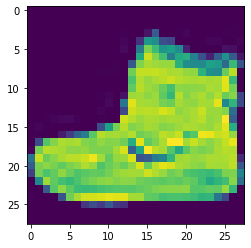

In [19]:
import matplotlib.pyplot as plt
plt.imshow(image.squeeze().numpy())
plt.show()

Looks like a shoe? Fashion-MNIST is a bunch of different black and white images of clothing with a corresponding label identifying the category the clothing belongs to. It looks like label 9 corresponds to shoes.

In order to nicely wrap the process of iterating through the dataset, we'll use a dataloader.

In [37]:
trainDataLoader = torch.utils.data.DataLoader(trainingdata,batch_size=128,shuffle=True) #loads images in batches of 64
testDataLoader = torch.utils.data.DataLoader(testdata,batch_size=128,shuffle=False)

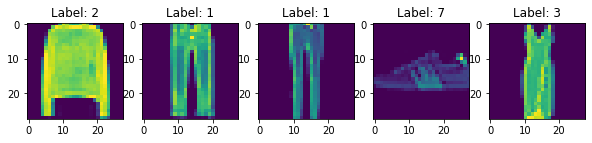

In [56]:
images, labels = next(iter(trainDataLoader))

plt.figure(figsize=(10,4))
for index in np.arange(0,5):
  plt.subplot(1,5,index+1)
  plt.title(f'Label: {labels[index].item()}')
  plt.imshow(images[index].squeeze().numpy())
     

In [ ]:
images[0].view(-1,28*28).shape

torch.Size([1, 784])

Now let's set up our model.

In [40]:
import torch.nn as nn
class LinearReg(torch.nn.Module):
  def __init__(self): # sets up architecture of the model with input and output node counts
    super(LinearReg, self).__init__()
    self.linear = torch.nn.Linear(28*28, 10) #(input dimension (pixels), output dimension (labels))
    self.model = nn.Sequential(
        nn.Linear(784, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 10),
        nn.Softmax()
    )


  
  def forward(self, x): #formats the input data so it can be read by the model
    x = x.view(-1, 28*28) # change so 784 vector long instead of 28x28 matrix
    return self.model(x) #gets outputs of labels 

model = LinearReg() # Step 1: architecture
loss = torch.nn.CrossEntropyLoss() # Step 2: loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # Step 3: training method
     

Lets train our model

In [41]:
train_loss_history = [] # used to track loss in the training dataset
test_loss_history = [] # used to track loss in the test dataset

# Training process
# training network on training data
for epoch in range(30):
  train_loss = 0.0
  test_loss = 0.0
  for i, data in enumerate(trainDataLoader): # loop through training data
    images, labels = data #splits data
    optimizer.zero_grad() #magic
    predicted_output = model(images) # run the model on the images and store its prediction
    fit = loss(predicted_output, labels) # calculates the loss function for model accuracy
    fit.backward() # computes the gradient of the loss tensor
    optimizer.step() #performs a round of optimization
    train_loss += fit.item() / len(trainingdata) #adds the loss to the total loss for that epoch
    #to compare because the lengths of training and test are not the same
# Validation
# How well are we doing on data we haven't seen yet?

  for i, data in enumerate(testDataLoader):
    with torch.no_grad():
      images, labels = data
      predicted_output = model(images)
      fit = loss(predicted_output, labels)
      test_loss += fit.item() / len(testdata)
  train_loss_history += [train_loss] 
  test_loss_history += [test_loss]
  print(f'Epoch {epoch}, Train loss {train_loss}, Test loss {test_loss}')

Epoch 0, Train loss 0.017995055870215097, Test loss 0.01818319368362427
Epoch 1, Train loss 0.017987454950809494, Test loss 0.018175337815284735
Epoch 2, Train loss 0.0179788884003957, Test loss 0.018165776729583753
Epoch 3, Train loss 0.017967976478735607, Test loss 0.018152995610237123
Epoch 4, Train loss 0.0179527165810267, Test loss 0.018134714484214783
Epoch 5, Train loss 0.017930102280775736, Test loss 0.018106296849250796
Epoch 6, Train loss 0.01789213991562526, Test loss 0.018055514264106752
Epoch 7, Train loss 0.017819386076927193, Test loss 0.017952286553382865
Epoch 8, Train loss 0.017655484159787488, Test loss 0.017698454928398135
Epoch 9, Train loss 0.017247387079397825, Test loss 0.017163346743583673
Epoch 10, Train loss 0.01673243439197542, Test loss 0.01666142706871032
Epoch 11, Train loss 0.016126654261350622, Test loss 0.015957448613643652
Epoch 12, Train loss 0.015404488694667824, Test loss 0.015252938663959497
Epoch 13, Train loss 0.014807573334376021, Test loss 0.0

Let's plot our loss by training epoch to see how we did.

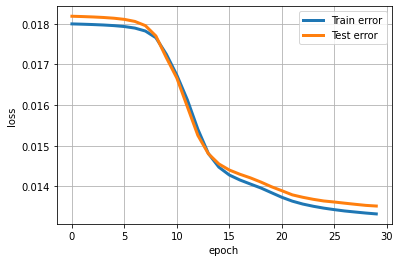

In [43]:
plt.plot(range(30),train_loss_history,'-',linewidth=3, label='Train error')
plt.plot(range(30),test_loss_history,'-',linewidth=3, label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.show()

Why is test loss larger than training loss? Because it is training on the training images and not the testing images.

We definitely see some improvement. Let's look at the images, the predictions our model makes and the true label.

Predicted: [9 2 1]


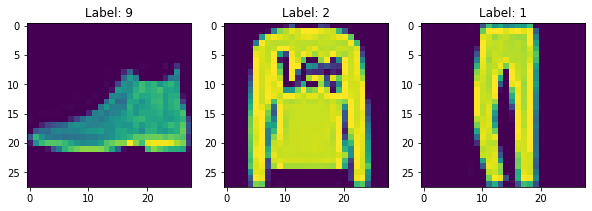

In [85]:
images, labels = next(iter(testDataLoader))
plt.figure(figsize=(10,10))

predicted_output = model(images)
print('Predicted:', torch.max(predicted_output, 1)[1].numpy()[0:3])

for index in np.arange(0,3): 
    plt.subplot(1,3,index+1)
    plt.title(f'Label: {labels[index].item()}')
    plt.imshow(images[index].cpu().squeeze().numpy())



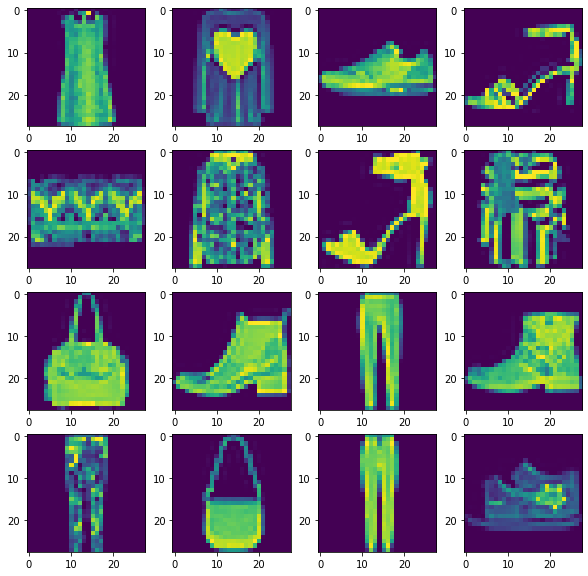

In [ ]:
plt.figure(figsize=(10,10))
for index in np.arange(0,16):
  plt.subplot(4,4,index+1)
  plt.imshow(images[index].cpu().squeeze().numpy())

Now for the labels and predicted labels.

In [44]:
images, labels = next(iter(trainDataLoader))
predicted_output = model(images)
print('Predicted:', torch.max(predicted_output, 1)[1])
fit = loss(predicted_output, labels)
print('True labels:', labels)
print(fit.item())


Predicted: tensor([2, 9, 8, 1, 1, 4, 5, 9, 0, 1, 2, 0, 5, 9, 2, 7, 3, 9, 2, 4, 1, 4, 7, 2,
        9, 7, 0, 5, 4, 7, 3, 3, 8, 4, 0, 1, 4, 8, 8, 8, 2, 4, 4, 4, 4, 7, 5, 1,
        8, 4, 9, 2, 8, 0, 4, 1, 5, 7, 0, 3, 5, 8, 3, 7, 0, 4, 2, 2, 2, 7, 5, 9,
        2, 8, 2, 3, 4, 9, 3, 1, 4, 3, 7, 2, 9, 1, 5, 1, 1, 5, 3, 4, 0, 5, 3, 5,
        5, 3, 3, 3, 5, 5, 9, 8, 5, 9, 4, 0, 1, 2, 3, 9, 3, 3, 5, 2, 2, 5, 2, 5,
        1, 7, 3, 0, 2, 3, 5, 5])
True labels: tensor([6, 9, 8, 1, 1, 4, 5, 9, 6, 1, 2, 0, 5, 9, 2, 7, 3, 9, 6, 0, 1, 6, 7, 1,
        9, 7, 0, 5, 4, 7, 6, 3, 8, 4, 3, 1, 4, 8, 8, 8, 2, 6, 6, 4, 4, 7, 5, 1,
        8, 4, 9, 2, 8, 0, 4, 1, 5, 7, 0, 0, 9, 2, 3, 9, 6, 4, 6, 2, 8, 7, 5, 5,
        2, 8, 6, 0, 4, 9, 3, 1, 4, 3, 7, 2, 9, 1, 5, 1, 1, 5, 3, 4, 3, 5, 6, 5,
        5, 3, 3, 3, 5, 5, 9, 8, 5, 9, 4, 0, 1, 2, 3, 9, 3, 3, 5, 2, 6, 5, 2, 5,
        1, 7, 6, 0, 6, 3, 5, 5])
1.6821812391281128
